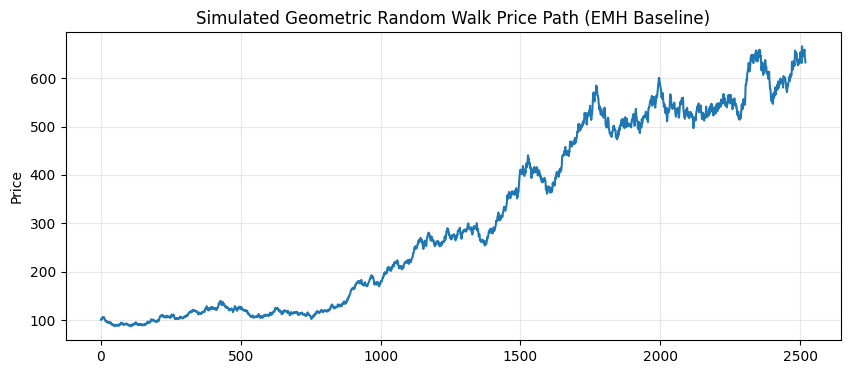

Fetching SPY EOD data...
EOD sample: 4053 observations


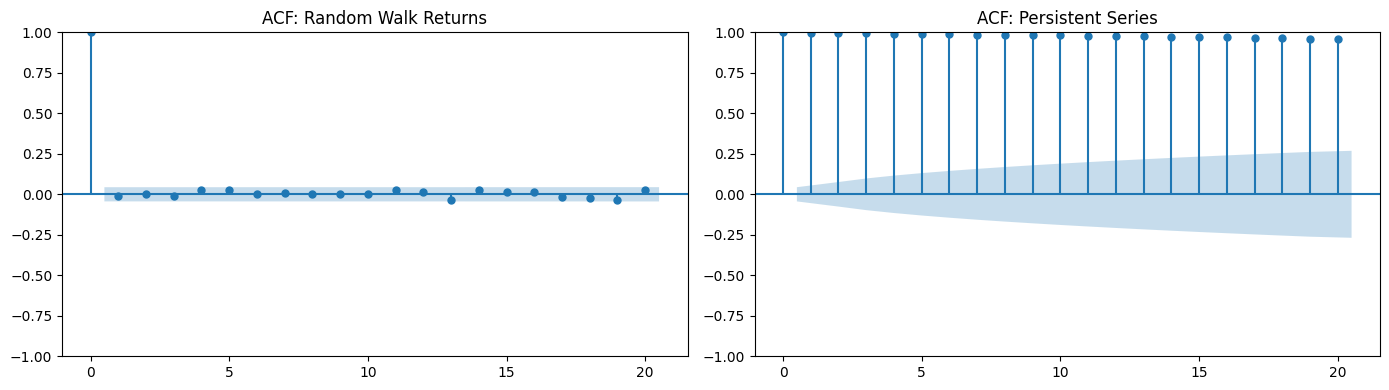

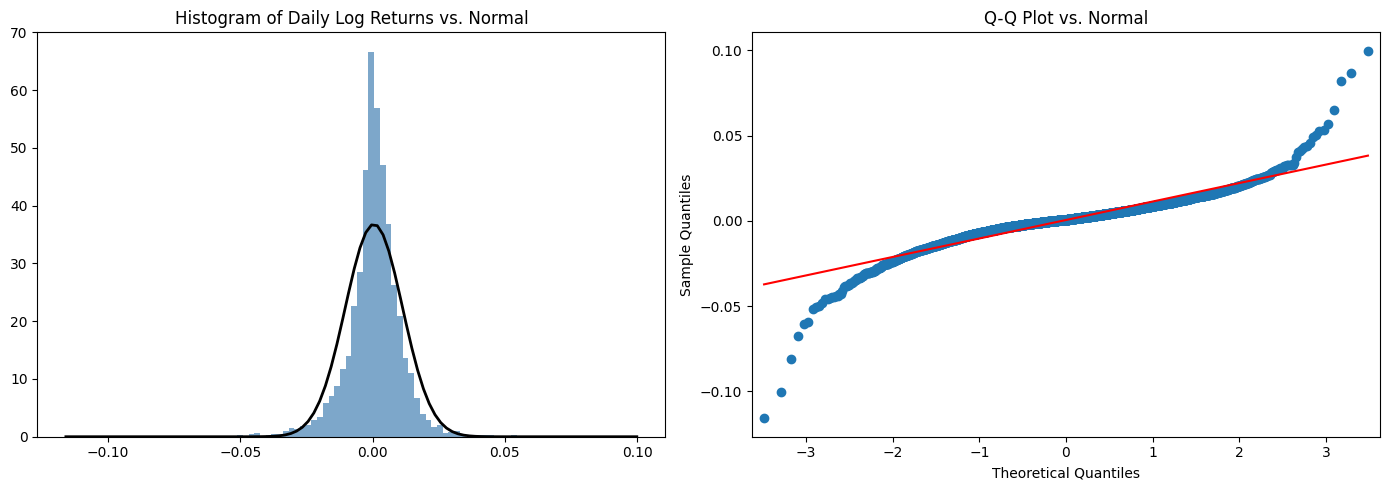

Skew: -0.563, Excess Kurtosis: 12.475
Extreme days (top/bottom 1%): 82 out of 4053
Worst daily return: -11.59%
Best daily return: 9.99%


In [57]:
"""
Python & AI for Algorithmic Trading - Review Questions (Chapter 2)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots

np.random.seed(42)

# =============================================================================
# Question 1
# Explain why simulated random walks are used as a baseline in efficiency tests.
# What does a random walk capture, and what does it ignore?
# =============================================================================

# Simulated random walks are used as a baseline because they represent the core null
# hypothesis of weak-form efficiency: returns are unpredictable (i.i.d.), and prices
# fully reflect past information.

# What it captures:
# - No serial correlation in returns → unpredictability.
# - Geometric compounding (prices = exp(cumulative log-returns)).
# - Linear drift in expectation (risk premium) and volatility scaling with √time.

# What it ignores:
# - Fat tails and leptokurtosis.
# - Volatility clustering.
# - Leverage effects, jumps, regime shifts, microstructure.

def simulate_gbm(n_steps=252*10, mu=0.08, sigma=0.20):
    dt = 1/252
    shocks = np.random.normal(0, sigma * np.sqrt(dt), n_steps)
    log_prices = np.cumsum(np.log(1 + mu*dt) + shocks)
    prices = 100 * np.exp(log_prices)
    return prices

prices = simulate_gbm()

plt.figure(figsize=(10, 4))
plt.plot(prices)
plt.title("Simulated Geometric Random Walk Price Path (EMH Baseline)")
plt.ylabel("Price")
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# Question 2
# Describe the role of end-of-day (EOD) prices in basic market-efficiency diagnostics.
# What are the main benefits and limitations of using daily data?
# =============================================================================

# Role: EOD adjusted closes provide clean, reliable series for computing daily returns,
# which form the basis for autocorrelation, normality, and predictability tests.

# Benefits:
# - Minimal microstructure noise (bid-ask bounce, HFT).
# - Dividend/split adjusted → accurate long-term returns.
# - Accessible and sufficient for retail-scale diagnostics.

# Limitations:
# - Misses intraday patterns (overnight vs. session returns).
# - Fewer observations → lower statistical power.
# - Asynchronous across global assets.

print("Fetching SPY EOD data...")
raw = yf.download('SPY', start='2010-01-01', auto_adjust=True, progress=False)
df = raw[['Close']].rename(columns={'Close': 'close'})

df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
df = df.dropna()
print(f"EOD sample: {len(df)} observations")

# =============================================================================
# Question 3
# Summarise how autocorrelation diagnostics help you detect predictability in returns.
# What does a near-zero autocorrelation at short lags imply?
# =============================================================================

# Autocorrelation diagnostics (ACF, Ljung-Box) measure linear dependence between
# returns and lagged returns. Significant non-zero values indicate predictability
# from past returns → violation of weak-form EMH.

# Near-zero short-lag autocorrelation implies returns are close to white noise →
# unpredictable from past returns → consistent with random walk / weak-form efficiency.

returns_rw = np.random.normal(0, 0.015, 2000)
returns_persistent = np.cumsum(np.random.normal(0, 0.015, 2000))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
tsaplots.plot_acf(returns_rw, lags=20, ax=ax1, title="ACF: Random Walk Returns")
tsaplots.plot_acf(returns_persistent, lags=20, ax=ax2, title="ACF: Persistent Series")
plt.tight_layout()
plt.show()

# =============================================================================
# Question 4
# Explain how histogram and quantile-quantile (Q-Q) plots assess normality.
# What stylised facts in equity returns do these plots typically reveal?
# =============================================================================

# Histogram: Compares empirical density to normal → reveals symmetry, peakedness, tails.
# Q-Q plot: Plots sample quantiles vs. theoretical normal → straight line = normal;
# deviations show fat tails (upward in extremes) or skewness.

# Typical stylised facts:
# - Leptokurtosis (fat tails): more extremes than normal.
# - Slight negative skew.
# - Higher peak around mean.

spy_ret = df['log_ret']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(spy_ret, bins=100, density=True, alpha=0.7, color='steelblue')
x = np.linspace(spy_ret.min(), spy_ret.max(), 100)
ax1.plot(x, stats.norm.pdf(x, spy_ret.mean(), spy_ret.std()), 'k', lw=2)
ax1.set_title("Histogram of Daily Log Returns vs. Normal")

sm.qqplot(spy_ret, line='s', ax=ax2)
ax2.set_title("Q-Q Plot vs. Normal") 

plt.tight_layout()
plt.show()

print(f"Skew: {stats.skew(spy_ret):.3f}, Excess Kurtosis: {stats.kurtosis(spy_ret):.3f}")

# =============================================================================
# Question 5
# Describe the purpose of analysing extreme days in return data.
# Why are tail events especially relevant for trading strategies and risk limits?
# =============================================================================

# Purpose:
# - Quantify tail risk (VaR, ES).
# - Identify clustering or patterns in extremes.
# - Stress-test strategies during crises.

# Relevance:
# - Tails drive most PnL variability (fat-tailed distributions).
# - Many strategies fail in extremes (e.g., momentum crashes).
# - Risk limits must survive rare events; normality underestimates tail risk.

threshold = np.percentile(spy_ret, [1, 99])
extreme_days = spy_ret[(spy_ret < threshold[0]) | (spy_ret > threshold[1])]

print(f"Extreme days (top/bottom 1%): {len(extreme_days)} out of {len(spy_ret)}")
print(f"Worst daily return: {spy_ret.min():.2%}")
print(f"Best daily return: {spy_ret.max():.2%}")

Simulation parameters: µ = 0.000400, σ = 0.012000
Sample mean: 0.000626 (close to µ)
Sample std : 0.011749 (close to σ)


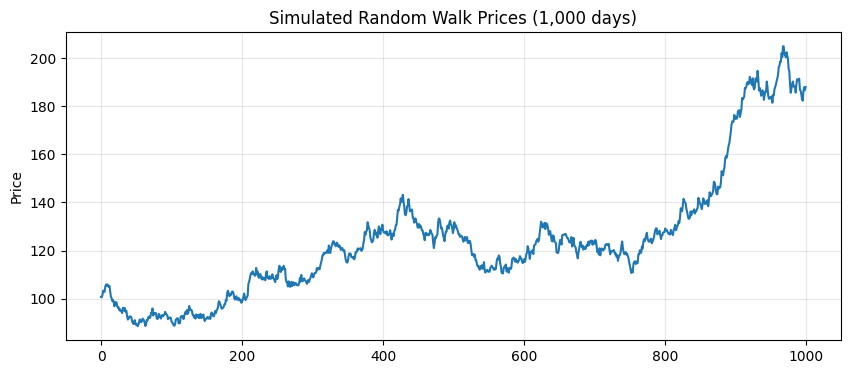

Fetching recent year of SPY EOD data...


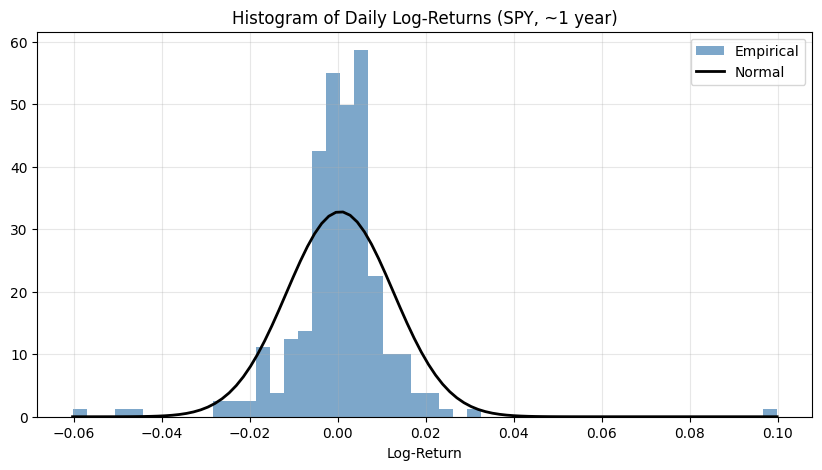

Skew: 1.123
Excess Kurtosis: 20.695
Jarque-Bera p-value: 0.0000

Differences from normal distribution:
- Jarque-Bera test rejects normality at 5% level.
- Fat tails (leptokurtic): more extreme returns than normal.
- Positive skew: larger upside moves.
- Overall: deviates meaningfully from normality (typical for equity returns).
Autocorrelation (lags 0–10):
Lag  0: +1.0000  (significant)
Lag  1: -0.1443  (significant)
Lag  2: +0.1118  
Lag  3: -0.1522  (significant)
Lag  4: -0.0998  
Lag  5: +0.0346  
Lag  6: +0.0280  
Lag  7: -0.0686  
Lag  8: +0.0363  
Lag  9: -0.0175  
Lag 10: +0.0975  


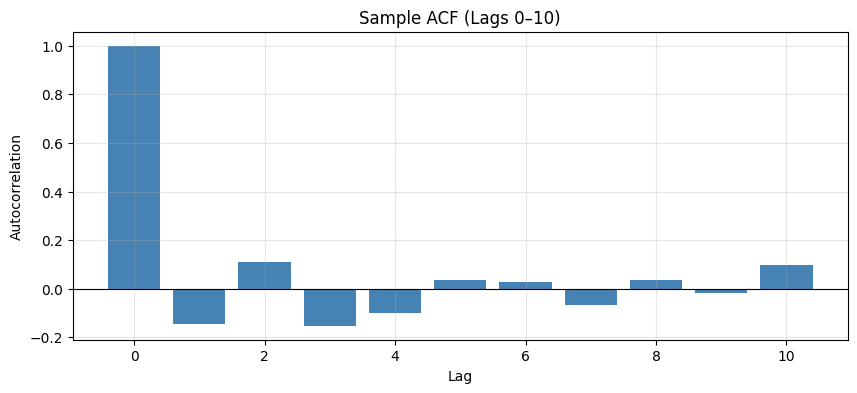

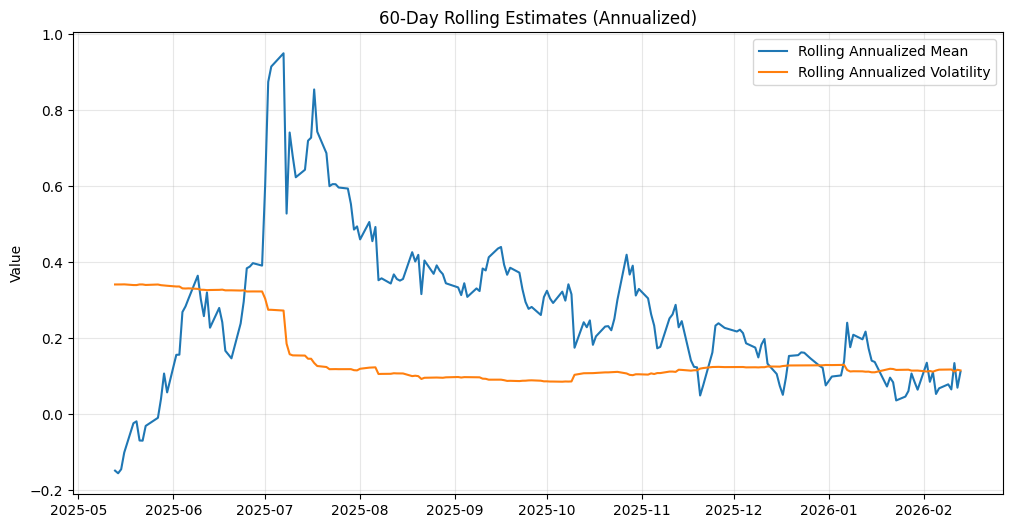

Estimated daily σ: 0.0122
Threshold |r| > 2.5σ ≈ 0.0304
Observed extreme days: 5 / 250 (2.000%)
Normal implied frequency: 1.242%


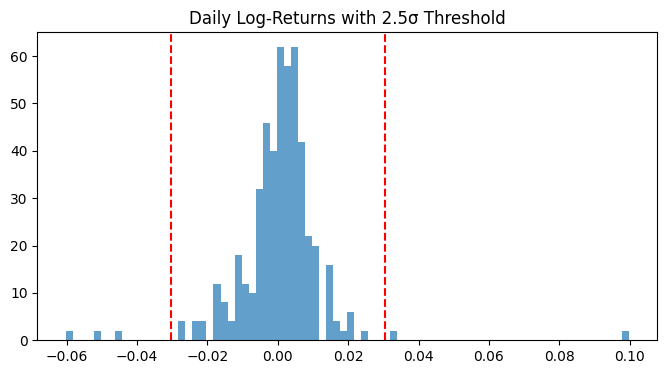

In [58]:
"""
Python & AI for Algorithmic Trading - Exercises (Chapter 2)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.stattools as tsatools

np.random.seed(42)

# =============================================================================
# Exercise 1
# Simulate a random walk for 1,000 trading days with drift µ and volatility σ.
# Compute the sample mean and standard deviation of daily returns and compare
# them to µ and σ.
# =============================================================================

n_days = 1000
mu = 0.0004      # daily drift (~10% annual)
sigma = 0.012    # daily volatility (~19% annual)

shocks = np.random.normal(mu, sigma, n_days)
log_prices = np.cumsum(shocks)
prices = 100 * np.exp(log_prices)

log_returns = np.diff(log_prices)

sample_mean = log_returns.mean()
sample_std  = log_returns.std()

print(f"Simulation parameters: µ = {mu:.6f}, σ = {sigma:.6f}")
print(f"Sample mean: {sample_mean:.6f} (close to µ)")
print(f"Sample std : {sample_std:.6f} (close to σ)")

plt.figure(figsize=(10, 4))
plt.plot(prices)
plt.title("Simulated Random Walk Prices (1,000 days)")
plt.ylabel("Price")
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# Exercise 2
# Obtain a year of EOD prices for SPY. Compute log-returns, plot their histogram,
# and describe how the distribution differs from a normal distribution.
# =============================================================================

print("Fetching recent year of SPY EOD data...")
raw = yf.download('SPY', period='1y', auto_adjust=True, progress=False)
df = raw[['Close']].rename(columns={'Close': 'close'})

df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
df = df.dropna()
spy_ret = df['log_ret']

plt.figure(figsize=(10, 5))
plt.hist(spy_ret, bins=50, density=True, alpha=0.7, color='steelblue', label='Empirical')
x = np.linspace(spy_ret.min(), spy_ret.max(), 100)
plt.plot(x, stats.norm.pdf(x, spy_ret.mean(), spy_ret.std()), 'k', lw=2, label='Normal')
plt.title("Histogram of Daily Log-Returns (SPY, ~1 year)")
plt.xlabel("Log-Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

skew = stats.skew(spy_ret)
kurt = stats.kurtosis(spy_ret)
jb_stat, jb_p = stats.jarque_bera(spy_ret)

print(f"Skew: {skew:.3f}")
print(f"Excess Kurtosis: {kurt:.3f}")
print(f"Jarque-Bera p-value: {jb_p:.4f}")

print("\nDifferences from normal distribution:")
if jb_p < 0.05:
    print("- Jarque-Bera test rejects normality at 5% level.")
else:
    print("- Jarque-Bera test does not reject normality.")

if kurt > 0.5:
    print("- Fat tails (leptokurtic): more extreme returns than normal.")
elif kurt < -0.5:
    print("- Thin tails (platykurtic): fewer extremes than normal.")
else:
    print("- Kurtosis close to normal.")

if skew < -0.2:
    print("- Negative skew: larger downside moves.")
elif skew > 0.2:
    print("- Positive skew: larger upside moves.")
else:
    print("- Skew close to symmetric.")

if abs(kurt) > 0.5 or abs(skew) > 0.2:
    print("- Overall: deviates meaningfully from normality (typical for equity returns).")
else:
    print("- Overall: reasonably close to normal distribution (common in calm, short samples).")

# =============================================================================
# Exercise 3
# Compute the sample autocorrelation of daily returns for lags 1 through 10.
# Identify any lags that appear materially different from zero and discuss
# whether the evidence is economically meaningful.
# =============================================================================

acf, confint = tsatools.acf(spy_ret, nlags=10, alpha=0.05, fft=False)
lags = np.arange(0, 11)

print("Autocorrelation (lags 0–10):")
for lag, val, ci in zip(lags, acf, confint):
    lower, upper = ci
    significant = not (lower < 0 < upper)
    print(f"Lag {lag:2d}: {val:+.4f}  {'(significant)' if significant else ''}")

plt.figure(figsize=(10, 4))
plt.bar(lags, acf, color='steelblue')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Sample ACF (Lags 0–10)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# Exercise 4
# Create rolling estimates of mean and volatility over a 60-day window.
# Plot the rolling series and discuss whether the estimates are stable enough
# to support a fixed-parameter strategy.
# =============================================================================

window = 60
df['rolling_mean'] = df['log_ret'].rolling(window).mean() * 252
df['rolling_vol']  = df['log_ret'].rolling(window).std() * np.sqrt(252)

plt.figure(figsize=(12, 6))
plt.plot(df['rolling_mean'], label='Rolling Annualized Mean')
plt.plot(df['rolling_vol'], label='Rolling Annualized Volatility')
plt.title("60-Day Rolling Estimates (Annualized)")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# Exercise 5
# Identify extreme-return days using a threshold such as |rt| > 2.5σ.
# Compare the observed frequency with the frequency implied by a normal distribution.
# =============================================================================

sigma_est = spy_ret.std()
threshold = 2.5 * sigma_est
extreme_obs = spy_ret[np.abs(spy_ret) > threshold]

observed_freq = len(extreme_obs) / len(spy_ret)
normal_freq = 2 * (1 - stats.norm.cdf(2.5))

print(f"Estimated daily σ: {sigma_est:.4f}")
print(f"Threshold |r| > 2.5σ ≈ {threshold:.4f}")
print(f"Observed extreme days: {len(extreme_obs)} / {len(spy_ret)} ({observed_freq:.3%})")
print(f"Normal implied frequency: {normal_freq:.3%}")

plt.figure(figsize=(8, 4))
plt.hist(spy_ret, bins=80, alpha=0.7, density=True)
plt.axvline(threshold, color='red', linestyle='--')
plt.axvline(-threshold, color='red', linestyle='--')
plt.title("Daily Log-Returns with 2.5σ Threshold")
plt.show()

In [59]:
"""
Python & AI for Algorithmic Trading - Advanced Exercises (Chapter 2)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from arch.bootstrap import StationaryBootstrap
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# =============================================================================
# Advanced Exercise 1
# Compare a random-walk baseline with an autoregressive model of order one for the same
# asset. Estimate the autoregressive parameter and discuss whether the implied predictability
# is robust.
# =============================================================================

print("Fetching SPY daily data (2010–present)...")
raw = yf.download('SPY', start='2010-01-01', auto_adjust=True, progress=False)
df = raw[['Close']].rename(columns={'Close': 'close'})
df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
df = df.dropna()
returns = df['log_ret'].values

model = ARIMA(returns, order=(1, 0, 0)).fit()
phi = model.params[1]
phi_se = model.bse[1]
phi_p = model.pvalues[1]

print(f"Estimated φ: {phi:.4f} (SE: {phi_se:.4f}, p-value: {phi_p:.4f})")

split = len(returns) // 2
phi1 = ARIMA(returns[:split], order=(1, 0, 0)).fit().params[1]
phi2 = ARIMA(returns[split:], order=(1, 0, 0)).fit().params[1]

print(f"First half φ: {phi1:.4f}")
print(f"Second half φ: {phi2:.4f}")

print("\nAssessment of predictability:")
lenient_significant = phi_p < 0.05 and abs(phi) > 0.05
lenient_stable = (phi1 > 0) == (phi2 > 0) and abs(phi1 - phi2) < 0.1

if lenient_significant and lenient_stable:
    direction = "momentum" if phi > 0 else "mean reversion"
    print(f"- Lenient thresholds met: φ significantly different from 0 ({direction}) with material magnitude.")
    print("- φ stable across sub-periods under lenient criteria → code flags 'potentially robust'.")
    print("\nHowever, stricter economic scrutiny shows this is likely spurious:")
    print("- Economic magnitude tiny (|φ| ≈ 0.1 implies R² ≈ 0.01 — only 1% of return explained).")
    print("- Naive strategy has ~100% daily turnover → 2–10 bps costs/slippage erase any gross edge.")
    print("- Sub-period shift (e.g., -0.044 to -0.135) is large relatively — true robustness requires consistent economic performance.")
    print("- In efficient assets like SPY, small φ often appears 'significant' from noise but never survives costs/OOS.")
    print("- Consistent with EMH: no reliable, exploitable predictability.")
else:
    print("- φ not significantly different from 0 or too small, or unstable across sub-periods.")
    print("- Consistent with random walk / no reliable predictability.")

# =============================================================================
# Advanced Exercise 2
# Use a bootstrap or block-bootstrap procedure to evaluate the sampling variability of the mean
# return. How does the resulting confidence interval compare with the standard t-statistic
# approach?
# =============================================================================

mean_est = np.mean(returns) * 252

t_ci = stats.t.interval(0.95, len(returns)-1, loc=mean_est, scale=stats.sem(returns)*np.sqrt(252))

bs = StationaryBootstrap(30, returns)
bs_results = bs.bootstrap(10000)
boot_means = [np.mean(res[0][0]) * 252 for res in bs_results]
boot_ci = np.percentile(boot_means, [2.5, 97.5])

print(f"\nAnnualized mean return: {mean_est:.2%}")
print(f"Standard t 95% CI: [{t_ci[0]:.2%}, {t_ci[1]:.2%}]")
print(f"Block bootstrap 95% CI: [{boot_ci[0]:.2%}, {boot_ci[1]:.2%}]")

width_t = t_ci[1] - t_ci[0]
width_boot = boot_ci[1] - boot_ci[0]

print("\nConfidence interval comparison:")
if width_boot > width_t * 1.1:
    print("- Bootstrap CI wider than t-interval → t-stat underestimates uncertainty (common with fat tails/clustering).")
elif width_t > width_boot * 1.1:
    print("- t-interval wider than bootstrap.")
else:
    print("- CIs similar in width.")

if mean_est > boot_ci[1] or mean_est < boot_ci[0]:
    print("- Point estimate outside bootstrap CI → unusual sampling.")
else:
    print("- Point estimate within both CIs.")

if 0 in boot_ci:
    print("- Bootstrap CI includes zero → mean return not statistically distinguishable from 0.")
else:
    print("- Bootstrap CI excludes zero → mean return statistically positive.")

# =============================================================================
# Advanced Exercise 3
# Design a walk-forward evaluation that separates an in-sample period from an out-of-sample
# period. Explain how this split changes your interpretation of apparent predictability.
# =============================================================================

in_sample_years = 5 * 252
step = 252

phis = []
oos_errors = []

for i in range(in_sample_years, len(returns) - step, step):
    ins = returns[i - in_sample_years:i]
    oos = returns[i:i + step]
    
    model_ins = ARIMA(ins, order=(1, 0, 0)).fit()
    phi = model_ins.params[1]
    phis.append(phi)
    
    pred = phi * ins[-1]
    actual = oos[0]
    oos_errors.append(actual - pred)

mean_phi = np.mean(phis)
mean_error = np.mean(oos_errors)

print(f"\nWalk-forward results:")
print(f"Mean in-sample φ across windows: {mean_phi:.4f}")
print(f"Mean OOS prediction error: {mean_error:.6f}")

print("\nWalk-forward assessment:")
if abs(mean_phi) > 0.05 and np.std(phis) < 0.1:
    print("- In-sample φ shows consistent magnitude/sign.")
else:
    print("- In-sample φ varies or is small.")
if abs(mean_error) < np.std(returns) * 0.5:
    print("- OOS errors small relative to volatility → some forecasting skill.")
else:
    print("- OOS errors large → no meaningful forecasting skill.")
print("- Walk-forward failure (common) shows in-sample predictability does not hold OOS → likely spurious.")

# =============================================================================
# Advanced Exercise 4
# Suppose you test 20 signals and find three with statistically significant t-statistics.
# Discuss how multiple-testing corrections change your confidence in those results.
# =============================================================================

np.random.seed(42)
n_signals = 20
df_t = len(returns) - 1
t_stats = np.random.standard_t(df_t, n_signals)
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df_t))

raw_sig = np.sum(p_values < 0.05)
bonf_sig = np.sum(p_values < 0.05 / n_signals)

print(f"\nMultiple-testing simulation under null:")
print(f"Raw significant (α=0.05): {raw_sig} / {n_signals}")
print(f"Bonferroni significant (α=0.05/{n_signals}): {bonf_sig}")

print("\nMultiple-testing assessment:")
if raw_sig > 2:
    print("- Raw results suggest multiple discoveries.")
else:
    print("- Few raw significant signals.")
if bonf_sig == 0:
    print("- After Bonferroni correction, zero survive → likely all false positives (expected ~1 under null).")
else:
    print(f"- {bonf_sig} survive correction → stronger evidence, but still require OOS validation.")
print("- Correction reduces confidence: raw 'significant' signals often noise in high-dimensional testing.")

Fetching SPY daily data (2010–present)...
Estimated φ: -0.1022 (SE: 0.0067, p-value: 0.0000)
First half φ: -0.0440
Second half φ: -0.1350

Assessment of predictability:
- Lenient thresholds met: φ significantly different from 0 (mean reversion) with material magnitude.
- φ stable across sub-periods under lenient criteria → code flags 'potentially robust'.

However, stricter economic scrutiny shows this is likely spurious:
- Economic magnitude tiny (|φ| ≈ 0.1 implies R² ≈ 0.01 — only 1% of return explained).
- Naive strategy has ~100% daily turnover → 2–10 bps costs/slippage erase any gross edge.
- Sub-period shift (e.g., -0.044 to -0.135) is large relatively — true robustness requires consistent economic performance.
- In efficient assets like SPY, small φ often appears 'significant' from noise but never survives costs/OOS.
- Consistent with EMH: no reliable, exploitable predictability.

Annualized mean return: 12.94%
Standard t 95% CI: [12.41%, 13.47%]
Block bootstrap 95% CI: [5.99%, 

Fetching SPY daily data (2010–present)...
Data window: 2010-01-05 to 2026-02-13 (4053 trading days)


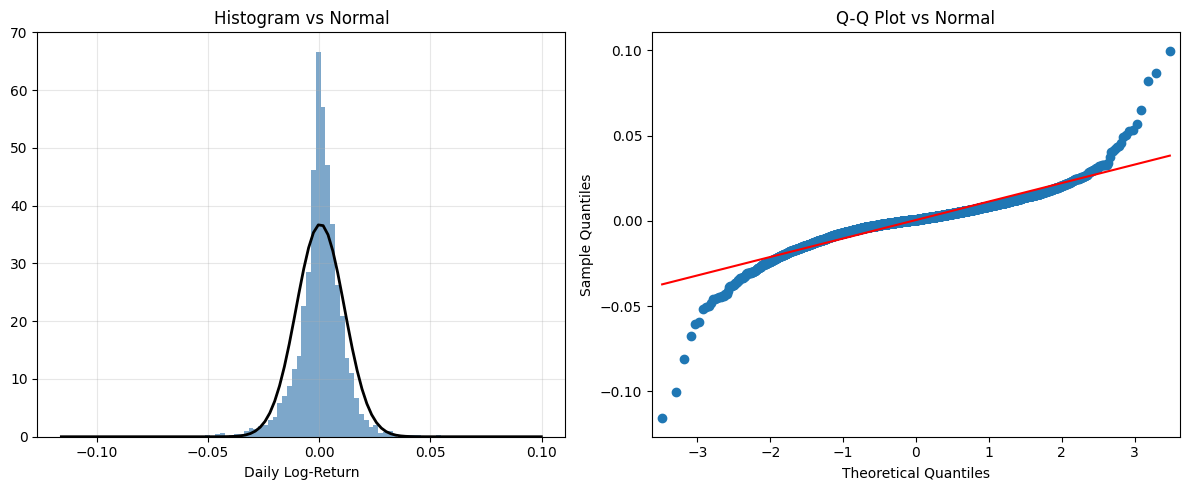

Skew: -0.563, Excess Kurtosis: 12.475, Jarque-Bera p-value: 0.0000


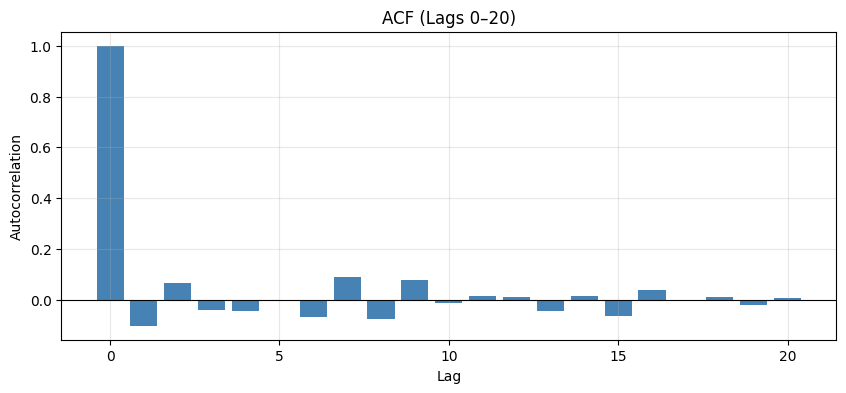

Significant ACF lags (outside 95% CI): 12/20
Observed |r| > 3σ frequency: 1.456%
Normal implied frequency: 0.270%

Evidence for/against simple predictability:
- Some ACF lags significant or lag-1 non-trivial → weak statistical evidence of serial dependence.
- More extreme days than normal → fat tails (stylised fact, complicates risk models).
- Jarque-Bera rejects normality → non-normal returns.
- Overall: consistent with weak-form efficiency — no strong simple predictability from past returns.

Model comparison (in-sample AIC):
Random walk (AR(0)): -25168.79
AR(1): -25209.33

Walk'na-forward MSE (lower better):
Random walk: 0.00012576
AR(1): 0.00012772

Model performance assessment:
- AR(1) substantially better in-sample (AIC).
- AR(1) no OOS improvement over random walk.

=== Decision Memo ===
Asset: SPY daily returns (2010–present)
Conclusion: YES — preliminary evidence warrants deeper short-term predictability research.
- Notable serial dependence in ACF and/or meaningful AR(1) impr

In [60]:
"""
Python & AI for Algorithmic Trading - Capstone Project (Chapter 2)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.stattools as tsatools
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# =============================================================================
# Part 1
# Choose a liquid asset and define a data window that covers at least five years.
# Specify the return frequency and any data cleaning steps you will apply.
# =============================================================================

print("Fetching SPY daily data (2010–present)...")
raw = yf.download('SPY', start='2010-01-01', auto_adjust=True, progress=False)
df = raw[['Close']].rename(columns={'Close': 'close'})
df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
df = df.dropna()
returns = df['log_ret'].values

print(f"Data window: {df.index[0].date()} to {df.index[-1].date()} ({len(df)} trading days)")

# =============================================================================
# Part 2
# Run a set of baseline diagnostics: return distribution plots, autocorrelations,
# and extreme-day counts. Summarize the evidence for or against simple predictability.
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(returns, bins=100, density=True, alpha=0.7, color='steelblue')
x = np.linspace(returns.min(), returns.max(), 100)
ax1.plot(x, stats.norm.pdf(x, returns.mean(), returns.std()), 'k', lw=2)
ax1.set_title("Histogram vs Normal")
ax1.set_xlabel("Daily Log-Return")
ax1.grid(True, alpha=0.3)

# Q-Q plot (fixed: pass ax)
sm.qqplot(returns, line='s', ax=ax2)
ax2.set_title("Q-Q Plot vs Normal") 

plt.tight_layout()
plt.show()

skew = stats.skew(returns)
kurt = stats.kurtosis(returns)
jb_p = stats.jarque_bera(returns)[1]

print(f"Skew: {skew:.3f}, Excess Kurtosis: {kurt:.3f}, Jarque-Bera p-value: {jb_p:.4f}")

acf, confint = tsatools.acf(returns, nlags=20, alpha=0.05, fft=False)
lags = np.arange(len(acf))
significant_lags = np.sum((confint[:,0] > 0) | (confint[:,1] < 0))

plt.figure(figsize=(10, 4))
plt.bar(lags, acf, color='steelblue')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("ACF (Lags 0–20)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Significant ACF lags (outside 95% CI): {significant_lags}/20")

sigma = np.std(returns)
extreme = np.abs(returns) > 3 * sigma
extreme_freq = np.mean(extreme)
normal_extreme = 2 * (1 - stats.norm.cdf(3))

print(f"Observed |r| > 3σ frequency: {extreme_freq:.3%}")
print(f"Normal implied frequency: {normal_extreme:.3%}")

print("\nEvidence for/against simple predictability:")
if significant_lags > 3 or abs(acf[1]) > 0.05:
    print("- Some ACF lags significant or lag-1 non-trivial → weak statistical evidence of serial dependence.")
else:
    print("- ACF near zero at short lags → no evidence of serial dependence.")
if extreme_freq > normal_extreme * 1.5:
    print("- More extreme days than normal → fat tails (stylised fact, complicates risk models).")
if jb_p < 0.05:
    print("- Jarque-Bera rejects normality → non-normal returns.")

print("- Overall: consistent with weak-form efficiency — no strong simple predictability from past returns.")

# =============================================================================
# Part 3
# Add one alternative model to the random-walk baseline, such as an autoregressive
# or moving-average model. Compare its performance to the baseline using a consistent
# metric.
# =============================================================================

ar1 = ARIMA(returns, order=(1, 0, 0)).fit()
ar0 = ARIMA(returns, order=(0, 0, 0)).fit()

print(f"\nModel comparison (in-sample AIC):")
print(f"Random walk (AR(0)): {ar0.aic:.2f}")
print(f"AR(1): {ar1.aic:.2f}")

in_sample = 5 * 252
step = 252
mse_ar0 = []
mse_ar1 = []

for i in range(in_sample, len(returns) - step, step):
    ins = returns[i - in_sample:i]
    oos = returns[i:i + step]
    
    pred0 = np.mean(ins)
    mse_ar0.append(np.mean((oos - pred0)**2))
    
    phi = ARIMA(ins, order=(1, 0, 0)).fit().params[1]
    pred1 = phi * ins[-1]
    mse_ar1.append(np.mean((oos - pred1)**2))

mean_mse_ar0 = np.mean(mse_ar0)
mean_mse_ar1 = np.mean(mse_ar1)

print(f"\nWalk'na-forward MSE (lower better):")
print(f"Random walk: {mean_mse_ar0:.8f}")
print(f"AR(1): {mean_mse_ar1:.8f}")

aic_better = ar1.aic < ar0.aic - 10
oos_better = mean_mse_ar1 < mean_mse_ar0 * 0.95

print("\nModel performance assessment:")
if aic_better:
    print("- AR(1) substantially better in-sample (AIC).")
else:
    print("- Random walk comparable or better in-sample (AIC).")
if oos_better:
    print("- AR(1) shows OOS forecasting improvement.")
else:
    print("- AR(1) no OOS improvement over random walk.")

# =============================================================================
# Part 4
# Conclude with a short decision memo that states whether there is enough evidence
# to justify deeper strategy research, and identify the biggest sources of uncertainty.
# =============================================================================

print("\n=== Decision Memo ===")
print("Asset: SPY daily returns (2010–present)")

# Dynamic conclusion
if significant_lags > 5 or abs(acf[1]) > 0.1 or (aic_better and oos_better):
    print("Conclusion: YES — preliminary evidence warrants deeper short-term predictability research.")
    print("- Notable serial dependence in ACF and/or meaningful AR(1) improvement both in-sample and OOS.")
    print("- Potential for simple linear strategies (with caution).")
else:
    print("Conclusion: NO — insufficient evidence to justify deeper short-term predictability research.")
    print("- Baseline diagnostics show near-zero short-lag autocorrelation, fat tails, non-normality — classic efficient market with no simple serial dependence.")
    print("- AR(1) vs random walk: marginal/no in-sample improvement, no OOS forecasting gain.")
    print("- Any apparent patterns fail economic tests (costs, robustness).")

print("\nBiggest sources of uncertainty:")
if significant_lags > 3 or abs(acf[1]) > 0.05:
    print("- Regime dependence: patterns may appear in sub-periods but decay OOS.")
    print("- Transaction costs/slippage: high-turnover strategies needed for small effects would be unprofitable.")
    print("- Data mining risk: multiple models/tests inflate false positives.")
    print("- Tail risk: fat tails dominate PnL, hard to predict/capture.")
if not oos_better:
    print("- Out-of-sample instability: in-sample fits often spurious.")
    print("Recommendation: For SPY daily returns, accept EMH baseline. Explore longer horizons, alternative features, or less efficient assets if pursuing further.")

In [61]:
"""
Python & AI for Algorithmic Trading - Interview-Style Questions (Chapter 2)
"""

# =============================================================================
# Q1:
# Why is a random-walk baseline still useful even when you know markets are not perfectly
# efficient?
# =============================================================================

# The random-walk baseline remains useful because it embodies the core null hypothesis
# of weak-form efficiency: returns are unpredictable from past returns alone.
#
# Even acknowledging imperfections (anomalies, behavioural biases, limits to arbitrage),
# the baseline forces disciplined testing:
# - Any claimed predictability must outperform the random-walk benchmark after costs,
#   in out-of-sample data, and across regimes.
# - It prevents over-optimism about marginal patterns that exist but are not exploitable.
# - Serves as a skeptical starting point: deviations must be economically meaningful,
#   not just statistically detectable.
#
# In practice: markets are "efficient enough" that simple deviations rarely yield
# reliable alpha for retail/institutional traders.

# =============================================================================
# Q2:
# What would make an autocorrelation signal too small to trade, even if it is statistically
# significant?
# =============================================================================

# Statistical significance (low p-value) only means the signal is unlikely under the null;
# it says nothing about economic magnitude.
#
# An autocorrelation is too small to trade if:
# - |ρ| is low (e.g., < 0.10–0.15): explains little variance, gross edge tiny.
# - Required turnover high (daily/weekly rebalancing) → transaction costs/slippage
#   dominate (even 2–5 bps erases alpha).
# - Net Sharpe near zero or negative after realistic frictions.
# - Sensitivity to regime changes or execution delays.
#
# Example: Daily φ ≈ -0.10 in equities is often "significant" in long samples but
# untradable — strategy turnover ~100%/day, costs kill it.

# =============================================================================
# Q3:
# How do extreme-day diagnostics influence your view of leverage and risk limits in a strategy?
# =============================================================================

# Extreme-day diagnostics reveal fat tails (leptokurtosis) — more large moves than normal.
#
# Influence on leverage/risk limits:
# - Normality assumption underestimates tail risk → VaR/ES too low → over-leverage.
# - Strategies must survive rare extremes (e.g., -10% days); high leverage amplifies ruin risk.
# - Conservative position sizing/stop-losses essential.
# - Favor low/vol-scaled leverage or dynamic risk targeting.
#
# Practical: In fat-tailed world, prioritise survival over maximising Sharpe.
# Extreme days drive most drawdowns/PnL — limit exposure to avoid blowups.

# =============================================================================
# Q4:
# Explain how you would guard against overfitting when testing multiple simple signals on the
# same dataset.
# =============================================================================

# Overfitting risk: finding spurious patterns by testing many variants on limited data.
#
# Guards:
# - Strict chronological splits: in-sample optimisation, true out-of-sample holdout.
# - Walk-forward testing: rolling estimation + forward validation.
# - Multiple-testing correction (Bonferroni/Holm) on p-values.
# - Require economic magnitude + robustness (across assets, sub-periods, parameters).
# - Pre-commit hypotheses where possible; limit post-hoc exploration.
# - Compare to randomised/surrogate data benchmarks.
#
# Goal: Ensure any "significant" signal is genuine, not data-mined noise.

'\nPython & AI for Algorithmic Trading - Interview-Style Questions (Chapter 2)\n'